<h1><center>Movie Tag Prediction :DATA SET </center></h1>

In [1]:
!pip install scikit-multilearn
!pip install xgboost
!pip install wordcloud

import re
import os
import tqdm
import nltk
import sqlite3
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import xgboost as xgb
from nltk.corpus import words
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from itertools import combinations
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline
from nltk.tokenize import sent_tokenize
from scipy.sparse import coo_matrix, hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import RandomizedSearchCV
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score,precision_score,recall_score,hamming_loss

%matplotlib inline
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings("ignore")
stemmer = SnowballStemmer('english')

%autosave 120

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhanu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bhanu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhanu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Autosaving every 120 seconds


# 1.DATA ANALYSIS:

## 1.1 LOADING DATA: 

In [2]:
data = pd.read_csv("mpst_full_data.csv")
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [3]:
import sqlalchemy
start = datetime.now()
if not os.path.isfile('mpst.db'):
    disk_engine = sqlalchemy.create_engine('sqlite:///mpst.db')
    start = datetime.now()
    chunksize = 15000
    j = 0
    index_start = 1
    for df in pd.read_csv('mpst_full_data.csv', chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start
        j+=1
        df.to_sql('mpst_full_data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
else:
    print("Database Already Exist.")

print("Time taken to run this cell :", datetime.now() - start)

Database Already Exist.
Time taken to run this cell : 0:00:00.000997


In [4]:
# removing duplicates
con = sqlite3.connect('mpst.db')
data_no_dup = pd.read_sql_query('SELECT title,plot_synopsis,tags,split,synopsis_source,COUNT(*) as cnt_dup FROM mpst_full_data GROUP BY title', con)
data_no_dup.shape

con.close()

In [5]:
data_no_dup.head()

,title,plot_synopsis,tags,split,synopsis_source,cnt_dup
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,imdb,1
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,wikipedia,1
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,wikipedia,1
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,wikipedia,1
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,wikipedia,1


## 1.2 Tag Analysis:

In [6]:
data_no_dup["tag_count"] = data_no_dup["tags"].apply(lambda text: len(str(text).split(", ")))
data_no_dup.head()

,title,plot_synopsis,tags,split,synopsis_source,cnt_dup,tag_count
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,imdb,1,1
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,wikipedia,1,1
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,wikipedia,1,4
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,wikipedia,1,2
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,wikipedia,1,6


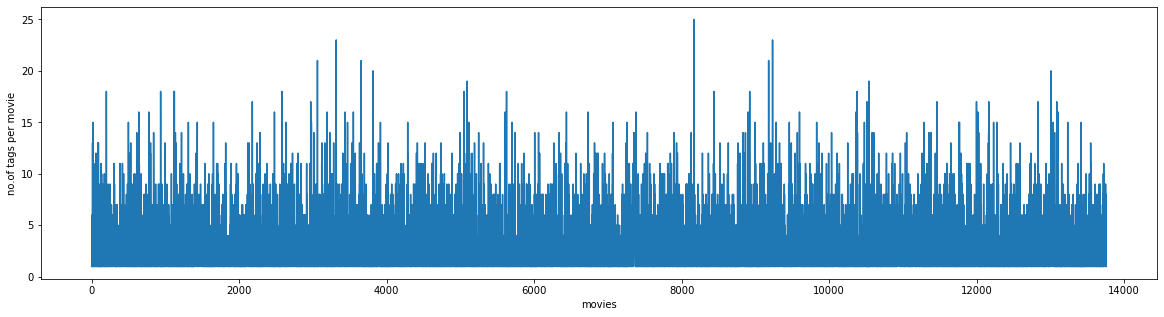

In [7]:
plt.figure(figsize=(20,5))
plt.plot(data_no_dup["tag_count"])
plt.xlabel('movies')
plt.ylabel("no.of tags per movie")
plt.show()

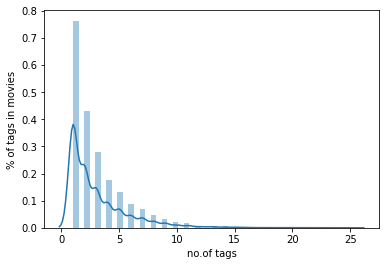

In [8]:
sns.distplot(data_no_dup["tag_count"])
plt.ylabel('% of tags in movies')
plt.xlabel('no.of tags')
plt.show()

In [9]:
data_no_dup["tag_count"].value_counts()

1     5040
2     2852
3     1837
4     1167
5      869
6      571
7      460
8      302
9      217
10     130
11     105
12      51
13      51
14      33
15      28
16      16
18      10
17       8
21       3
19       2
20       2
23       2
25       1
Name: tag_count, dtype: int64

In [10]:
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(", ") )
tag_vect = vectorizer.fit_transform(data_no_dup["tags"])

In [11]:
print("Number of data points :", tag_vect.shape[0])
print("Number of unique tags :", tag_vect.shape[1])

Number of data points : 13757
Number of unique tags : 71


In [12]:
tags = vectorizer.get_feature_names()
print("unique tags: \n", tags[:])

unique tags: 
 ['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 'anti war', 'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christian film', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'good versus evil', 'gothic', 'grindhouse film', 'haunting', 'historical', 'historical fiction', 'home movie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue', 'magical realism', 'melodrama', 'murder', 'mystery', 'neo noir', 'non fiction', 'paranormal', 'philosophical', 'plot twist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer', 'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']


In [13]:
#zipping tags and tags_count into one list
freqs = tag_vect.sum(axis=0).A1
result = list(zip(tags, freqs))

print((result))

[('absurd', 259), ('action', 605), ('adult comedy', 124), ('allegory', 123), ('alternate history', 98), ('alternate reality', 198), ('anti war', 108), ('atmospheric', 385), ('autobiographical', 43), ('avant garde', 213), ('blaxploitation', 73), ('bleak', 210), ('boring', 519), ('brainwashing', 103), ('christian film', 39), ('claustrophobic', 80), ('clever', 86), ('comedy', 1795), ('comic', 110), ('cruelty', 422), ('cult', 2531), ('cute', 190), ('dark', 387), ('depressing', 196), ('dramatic', 402), ('entertaining', 726), ('fantasy', 492), ('feel-good', 74), ('flashback', 2801), ('good versus evil', 793), ('gothic', 400), ('grindhouse film', 61), ('haunting', 132), ('historical', 266), ('historical fiction', 118), ('home movie', 148), ('horror', 455), ('humor', 803), ('insanity', 585), ('inspiring', 116), ('intrigue', 154), ('magical realism', 51), ('melodrama', 423), ('murder', 5375), ('mystery', 500), ('neo noir', 700), ('non fiction', 32), ('paranormal', 501), ('philosophical', 222), 

In [14]:
tag_counts = pd.DataFrame(result,columns=['tag','tag_counts'])
tag_counts.head()

,tag,tag_counts
0,absurd,259
1,action,605
2,adult comedy,124
3,allegory,123
4,alternate history,98


In [15]:
tag_counts['tag_counts'].describe()

count      71.000000
mean      587.028169
std       954.159166
min        32.000000
25%       116.500000
50%       225.000000
75%       527.500000
max      5375.000000
Name: tag_counts, dtype: float64

In [16]:
tag_counts_sorted = tag_counts.sort_values(['tag_counts'], ascending=False)
tag_counts = tag_counts_sorted['tag_counts'].values
tag_counts

array([5375, 4138, 2801, 2729, 2531, 2313, 1800, 1795, 1026,  803,  793,
        780,  726,  700,  618,  605,  585,  536,  519,  501,  500,  492,
        455,  423,  422,  402,  400,  387,  385,  346,  285,  272,  266,
        259,  242,  225,  222,  213,  210,  202,  198,  196,  191,  190,
        184,  156,  154,  148,  132,  124,  123,  118,  117,  116,  110,
        108,  103,   98,   94,   86,   80,   77,   74,   73,   71,   61,
         51,   50,   43,   39,   32], dtype=int64)

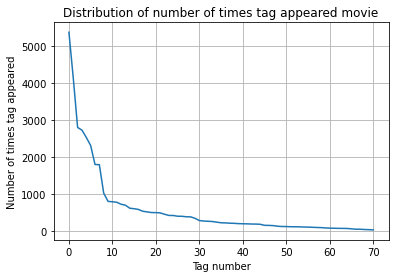

In [17]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared movie")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

In [18]:
tag_synop_count = tag_vect.sum(axis=1).tolist()
#Converting each value in the 'tag_synop_count' to integer.
tag_synop_count=[int(j) for i in tag_synop_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_synop_count)))

print( "Maximum number of tags per movie: %d"%max(tag_synop_count))
print( "Minimum number of tags per movie: %d"%min(tag_synop_count))
print( "Avg. number of tags per movie: %f"% ((sum(tag_synop_count)*1.0)/len(tag_synop_count)))

We have total 13757 datapoints.
Maximum number of tags per movie: 25
Minimum number of tags per movie: 1
Avg. number of tags per movie: 3.029658


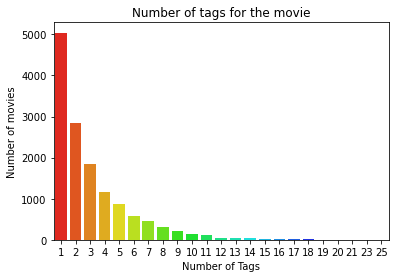

In [19]:
sns.countplot(tag_synop_count, palette='gist_rainbow')
plt.title("Number of tags for the movie")
plt.xlabel("Number of Tags")
plt.ylabel("Number of movies")
plt.show()

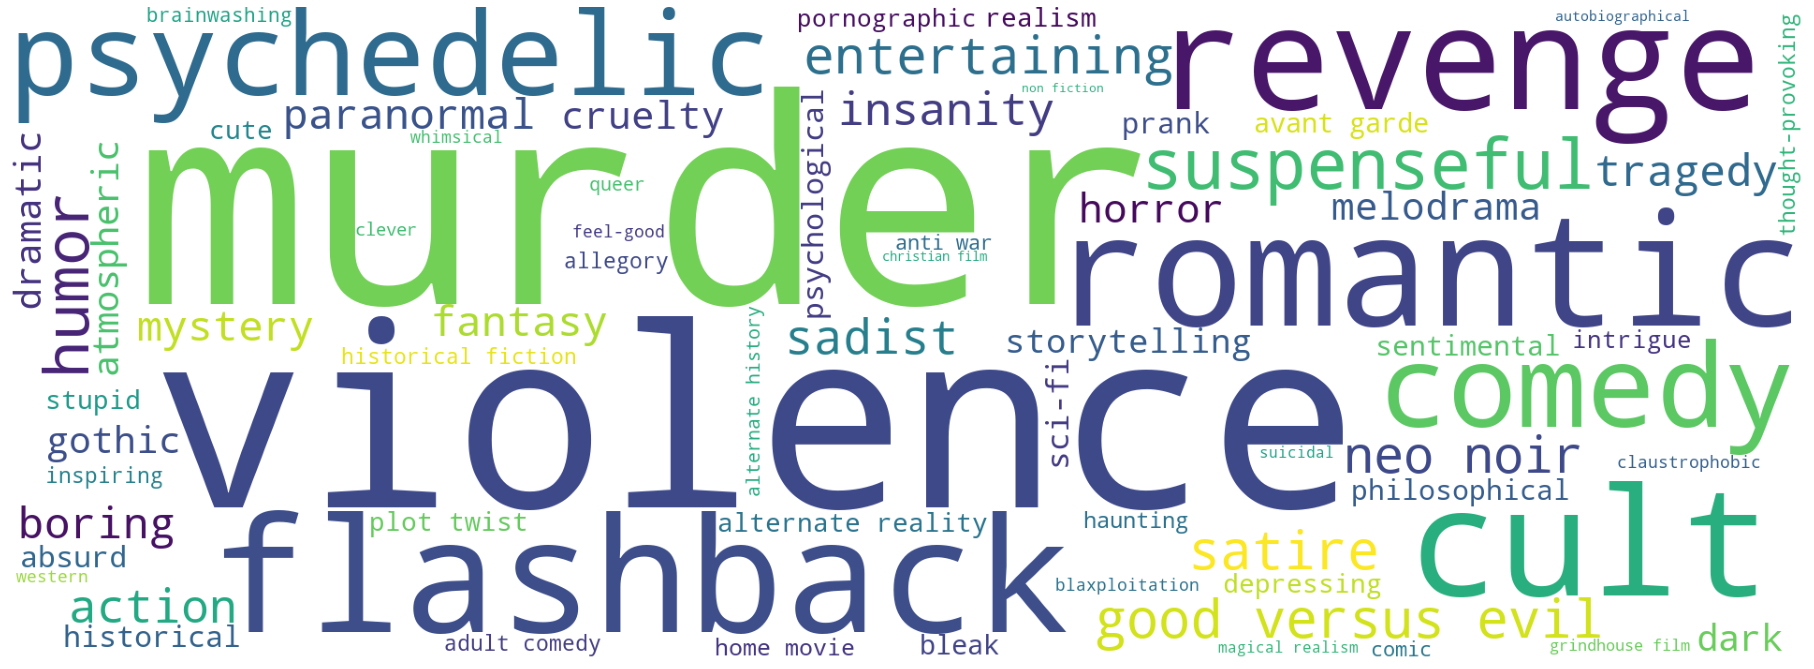

In [20]:
result = dict(zip(tags, freqs))
words = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='white', width = 1923, height = 700,).generate_from_frequencies(words)

fig = plt.figure(figsize=(25, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

## 1.3 Synopsis Analysis

In [176]:
data_no_dup["synopsis_count"] = data_no_dup["plot_synopsis"].apply(lambda text: len(str(text).split(" ")))
data_no_dup.head()

,title,plot_synopsis,tags,split,synopsis_source,cnt_dup,tag_count,synopsis_count
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,imdb,1,1,648
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,wikipedia,1,1,353
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,wikipedia,1,4,699
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,wikipedia,1,2,665
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,wikipedia,1,6,1694


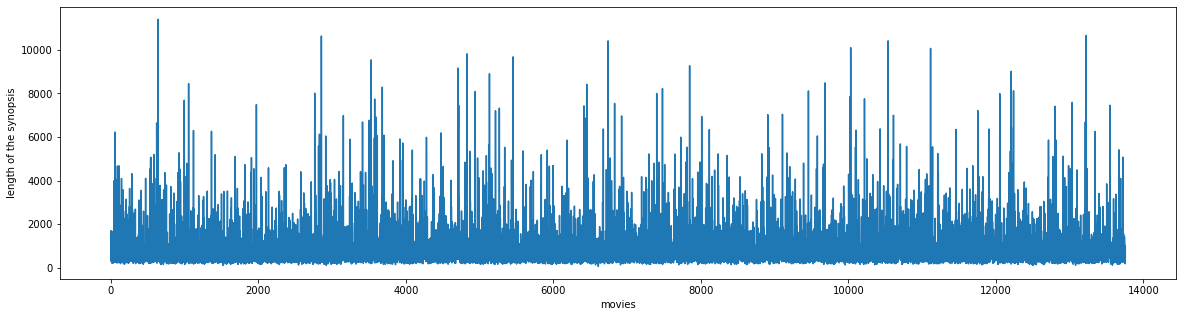

In [177]:
plt.figure(figsize=(20,5))
plt.plot(data_no_dup['synopsis_count'])
plt.xlabel("movies")
plt.ylabel("length of the synopsis")
plt.show()

In [178]:
data_no_dup["synopsis_sent_count"] = data_no_dup["plot_synopsis"].apply(lambda text: len(str(text).split(".")))
data_no_dup.head()

,title,plot_synopsis,tags,split,synopsis_source,cnt_dup,tag_count,synopsis_count,synopsis_sent_count
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,imdb,1,1,648,26
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,wikipedia,1,1,353,14
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,wikipedia,1,4,699,39
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,wikipedia,1,2,665,41
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,wikipedia,1,6,1694,140


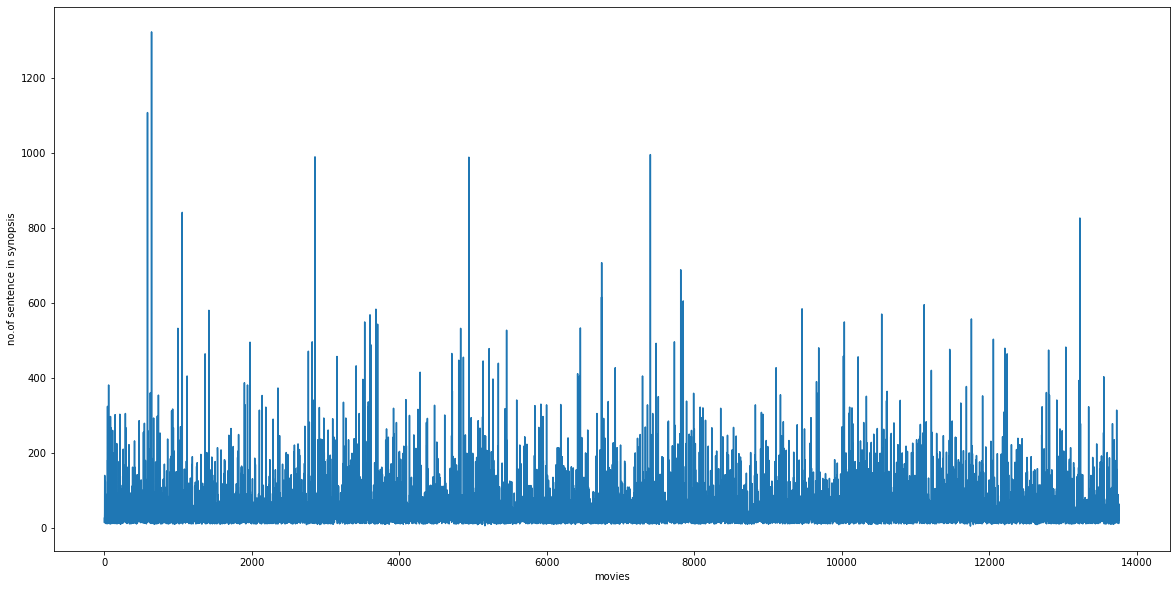

In [179]:
plt.figure(figsize=(20,10))
plt.plot(data_no_dup['synopsis_sent_count'])
plt.xlabel("movies")
plt.ylabel("no.of sentence in synopsis")
plt.show()

## 1.4 Source Analysis:

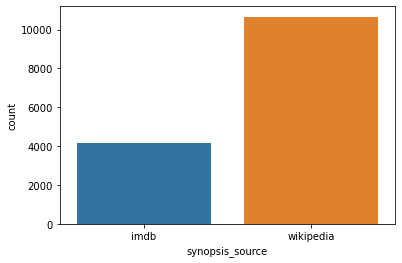

In [180]:
# most of the data is taken from wikipedia and imdb
sns.countplot(data['synopsis_source'])
plt.show()

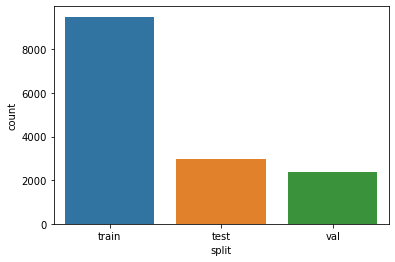

In [181]:
sns.countplot(data['split'])
plt.show()

## 1.5 Data Cleaning:

In [182]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [183]:
stopwords = set(stopwords.words('english'))

In [184]:
sno = nltk.stem.SnowballStemmer('english')

In [185]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [186]:
preprocessed_synop = []
for sentance in tqdm(data_no_dup['plot_synopsis'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    stemmed_sentence = []
    for e in sentance.split():
        if e.lower() not in stopwords:
            s=(sno.stem(lemmatizer.lemmatize(e.lower()))).encode('utf8')#lemitizing and stemming each word
            stemmed_sentence.append(s)
    sentance = b' '.join(stemmed_sentence)
    preprocessed_synop.append(sentance)
    
data_no_dup['CleanedSynopsis']=preprocessed_synop #adding a column of CleanedText which displays the data after pre-processing of the review 
data_no_dup['CleanedSynopsis']=data_no_dup['CleanedSynopsis'].str.decode("utf-8")

100%|████████████████████████████████████████████████████████████████████████████| 13757/13757 [04:12<00:00, 54.53it/s]


In [187]:
data_no_dup["CleanedSynopsis"][0]

'set hamburg west germani sever crimin take advantag german privaci bank law use safe deposit box german bank store larg amount illicit cash includ la vega mobster known attorney robert webber well ruthless drug smuggler known candi man arthur brauss crook overbear u armi sergeant scott bradi meek manner partner major robert stile conspir big heroin lsd smuggl score joe collin warren beatti american bank secur consult spi make mysteri elabor prepar steal money total million help dawn divin goldi hawn hooker heart gold day robberi joe dawn phone bomb threat bank presid mr kessel gert fr creat divers joe lock insid bank vault gold bar normal display lobbi suppos save bank close evacu joe us duplic key empti crimin three safe deposit box dawn larg size deposit box impli joe obtain necessari bank info secret copi crimin key engag sexual tryst dawn despit fact kessel insist burn wall rescu joe instead wait time lock open joe succeed heist hail hero prevent robberi gold bar next day three cr

In [188]:
#saving cleaned data to csv file 
data_no_dup.to_csv('cleaned_data.csv',index=False)


In [189]:
data=data_no_dup

In [190]:
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(", ") )
tag_vect = vectorizer.fit_transform(data_no_dup["tags"])

print("Number of data points :", tag_vect.shape[0])
print("Number of unique tags :", tag_vect.shape[1])

tag = vectorizer.get_feature_names()
print("unique tags: \n", tag[:])

Number of data points : 13757
Number of unique tags : 71
unique tags: 
 ['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 'anti war', 'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christian film', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'good versus evil', 'gothic', 'grindhouse film', 'haunting', 'historical', 'historical fiction', 'home movie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue', 'magical realism', 'melodrama', 'murder', 'mystery', 'neo noir', 'non fiction', 'paranormal', 'philosophical', 'plot twist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer', 'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western'

In [191]:
#converting tags sparse matrix into dataframe
tags=pd.DataFrame(tag_vect.toarray())

In [192]:
tags.columns = ['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 'anti war',\
                'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation', 'bleak', 'boring', 'brainwashing',\
                'christian film', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark',\
                'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'good versus evil', 'gothic',\
                'grindhouse film', 'haunting', 'historical', 'historical fiction', 'home movie', 'horror', 'humor', 'insanity',\
                'inspiring', 'intrigue', 'magical realism', 'melodrama', 'murder', 'mystery', 'neo noir', 'non fiction',\
                'paranormal', 'philosophical', 'plot twist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer',\
                'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid',\
                'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']
tags.head()

,absurd,action,adult comedy,allegory,alternate history,alternate reality,anti war,atmospheric,autobiographical,avant garde,...,sentimental,storytelling,stupid,suicidal,suspenseful,thought-provoking,tragedy,violence,western,whimsical
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [193]:
#concatenating data and tags dataframes
data_with_all_tags = pd.concat([data,tags],axis=1)
data_with_all_tags

,title,plot_synopsis,tags,split,synopsis_source,cnt_dup,tag_count,synopsis_count,synopsis_sent_count,CleanedSynopsis,...,sentimental,storytelling,stupid,suicidal,suspenseful,thought-provoking,tragedy,violence,western,whimsical
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,imdb,1,1,648,26,set hamburg west germani sever crimin take adv...,...,0,0,0,0,0,0,0,0,0,0
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,wikipedia,1,1,353,14,grader name griffin bing decid gather entir gr...,...,0,0,0,0,0,0,0,0,0,0
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,wikipedia,1,4,699,39,gari hook new recruit british armi take leav m...,...,0,0,0,0,1,0,0,1,0,0
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,wikipedia,1,2,665,41,sergeant dragon jacki chan part hong kong mari...,...,0,0,0,0,0,0,0,1,0,0
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,wikipedia,1,6,1694,140,pretoria south africa major charl bolton rod m...,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13752,Ängelby,Vera Fors lives an ordinary life with her husb...,"paranormal, murder",train,wikipedia,1,2,176,12,vera for life ordinari life husband two child ...,...,0,0,0,0,0,0,0,0,0,0
13753,Ådalen 31,"In 1931, the working-class family Andersson of...",romantic,val,wikipedia,1,1,419,26,work class famili andersson dalen take part ma...,...,0,0,0,0,0,0,0,0,0,0
13754,Él,The film opens during a foot washing ceremony ...,autobiographical,train,wikipedia,1,1,975,52,film open foot wash ceremoni christian church ...,...,0,0,0,0,0,0,0,0,0,0
13755,Ôdishon,"Shigeharu Aoyama (Ryo Ishibashi), a middle-age...","cruelty, murder, cult, violence, flashback, ps...",train,imdb,1,8,997,64,shigeharu aoyama ryo ishibashi middl age widow...,...,0,0,0,0,1,0,0,1,0,0


In [194]:
#After concatenating two data frames their is a possiblity of null values.
#checking for null values
#True:null values are present
#False:null values are not present
data_with_all_tags.isnull().values.any()

False

In [195]:
data_with_all_tags.head()

,title,plot_synopsis,tags,split,synopsis_source,cnt_dup,tag_count,synopsis_count,synopsis_sent_count,CleanedSynopsis,...,sentimental,storytelling,stupid,suicidal,suspenseful,thought-provoking,tragedy,violence,western,whimsical
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,imdb,1,1,648,26,set hamburg west germani sever crimin take adv...,...,0,0,0,0,0,0,0,0,0,0
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,wikipedia,1,1,353,14,grader name griffin bing decid gather entir gr...,...,0,0,0,0,0,0,0,0,0,0
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,wikipedia,1,4,699,39,gari hook new recruit british armi take leav m...,...,0,0,0,0,1,0,0,1,0,0
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,wikipedia,1,2,665,41,sergeant dragon jacki chan part hong kong mari...,...,0,0,0,0,0,0,0,1,0,0
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,wikipedia,1,6,1694,140,pretoria south africa major charl bolton rod m...,...,0,0,0,0,0,0,1,1,0,0


In [196]:
data_with_all_tags.to_csv('data_with_all_tags.csv',index=False)

In [198]:
conn = sqlite3.connect('data.db')
data_with_all_tags.to_sql('data', conn, if_exists='replace', index=False)
train = pd.read_sql("Select * From data where split = 'train' OR split='val'",conn)
test =  pd.read_sql("Select * From data where split = 'test'",conn)
conn.close()

# Train tag analysis

In [199]:
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(", ") )
train_tag_vect = vectorizer.fit_transform(train["tags"])

print("Number of data points :", train_tag_vect.shape[0])
print("Number of unique tags :", train_tag_vect.shape[1])

tags = vectorizer.get_feature_names()

#zipping tags and tags_count into one list
freqs = train_tag_vect.sum(axis=0).A1
result = list(zip(tags, freqs))

print((result))

Number of data points : 10989
Number of unique tags : 71
[('absurd', 203), ('action', 484), ('adult comedy', 96), ('allegory', 104), ('alternate history', 80), ('alternate reality', 163), ('anti war', 80), ('atmospheric', 311), ('autobiographical', 35), ('avant garde', 170), ('blaxploitation', 63), ('bleak', 170), ('boring', 404), ('brainwashing', 86), ('christian film', 31), ('claustrophobic', 65), ('clever', 73), ('comedy', 1432), ('comic', 85), ('cruelty', 326), ('cult', 2001), ('cute', 152), ('dark', 305), ('depressing', 155), ('dramatic', 323), ('entertaining', 571), ('fantasy', 390), ('feel-good', 63), ('flashback', 2228), ('good versus evil', 618), ('gothic', 325), ('grindhouse film', 49), ('haunting', 112), ('historical', 203), ('historical fiction', 94), ('home movie', 119), ('horror', 368), ('humor', 635), ('insanity', 460), ('inspiring', 84), ('intrigue', 114), ('magical realism', 48), ('melodrama', 336), ('murder', 4294), ('mystery', 389), ('neo noir', 562), ('non fiction',

In [201]:
def tags_to_choose(n):
    t = train_tag_vect.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=train_tag_vect[:,sorted_tags_i[:n]]
    return multilabel_yn

def analysis_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

analysis = []
total_tags=train_tag_vect.shape[1]
total_qs=data.shape[0]
for i in range(total_tags):
    analysis.append(np.round(((total_qs-analysis_fn(i))/total_qs)*100,3))
print(train_tag_vect)

  (0, 28)	1
  (1, 65)	1
  (1, 45)	1
  (1, 43)	1
  (1, 68)	1
  (2, 68)	1
  (2, 20)	1
  (3, 28)	1
  (3, 43)	1
  (3, 68)	1
  (3, 6)	1
  (3, 67)	1
  (3, 33)	1
  (4, 43)	1
  (5, 68)	1
  (5, 56)	1
  (6, 43)	1
  (7, 28)	1
  (8, 52)	1
  (9, 68)	1
  (9, 57)	1
  (10, 21)	1
  (11, 57)	1
  (12, 28)	1
  (12, 43)	1
  :	:
  (10980, 20)	1
  (10980, 56)	1
  (10981, 65)	1
  (10981, 43)	1
  (10981, 68)	1
  (10981, 57)	1
  (10981, 11)	1
  (10982, 20)	1
  (10982, 17)	1
  (10983, 28)	1
  (10983, 58)	1
  (10983, 17)	1
  (10984, 43)	1
  (10984, 47)	1
  (10985, 57)	1
  (10986, 8)	1
  (10987, 28)	1
  (10987, 65)	1
  (10987, 43)	1
  (10987, 68)	1
  (10987, 20)	1
  (10987, 52)	1
  (10987, 19)	1
  (10987, 58)	1
  (10988, 43)	1


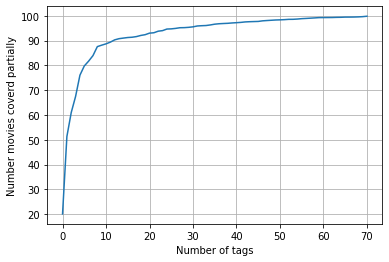

with  5 tags we are covering  79.763 % of movies
with  10 tags we are covering  88.682 % of movies
with  18 tags we are covering  92.069 % of movies
with  20 tags we are covering  93.0 % of movies
with  26 tags we are covering  94.912 % of movies
with  30 tags we are covering  95.537 % of movies
with  35 tags we are covering  96.613 % of movies
with  40 tags we are covering  97.216 % of movies
with  50 tags we are covering  98.357 % of movies
with  60 tags we are covering  99.273 % of movies


In [202]:
fig, ax = plt.subplots()
ax.plot(analysis)
plt.xlabel("Number of tags")
plt.ylabel("Number movies coverd partially")
plt.grid()
plt.show()

print("with ",5,"tags we are covering ",analysis[5],"% of movies")
print("with ",10,"tags we are covering ",analysis[10],"% of movies")
print("with ",18,"tags we are covering ",analysis[18],"% of movies")
print("with ",20,"tags we are covering ",analysis[20],"% of movies")
print("with ",26,"tags we are covering ",analysis[26],"% of movies")
print("with ",30,"tags we are covering ",analysis[30],"% of movies")
print("with ",35,"tags we are covering ",analysis[35],"% of movies")
print("with ",40,"tags we are covering ",analysis[40],"% of movies")
print("with ",50,"tags we are covering ",analysis[50],"% of movies")
print("with ",60,"tags we are covering ",analysis[60],"% of movies")

# Test tag analysis

In [203]:
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(", ") )
test_tag_vect = vectorizer.fit_transform(test["tags"])

print("Number of data points :", test_tag_vect.shape[0])
print("Number of unique tags :", test_tag_vect.shape[1])

tags = vectorizer.get_feature_names()

#zipping tags and tags_count into one list
freqs = test_tag_vect.sum(axis=0).A1
result = list(zip(tags, freqs))

print((result))

Number of data points : 2768
Number of unique tags : 71
[('absurd', 56), ('action', 121), ('adult comedy', 28), ('allegory', 19), ('alternate history', 18), ('alternate reality', 35), ('anti war', 28), ('atmospheric', 74), ('autobiographical', 8), ('avant garde', 43), ('blaxploitation', 10), ('bleak', 40), ('boring', 115), ('brainwashing', 17), ('christian film', 8), ('claustrophobic', 15), ('clever', 13), ('comedy', 363), ('comic', 25), ('cruelty', 96), ('cult', 530), ('cute', 38), ('dark', 82), ('depressing', 41), ('dramatic', 79), ('entertaining', 155), ('fantasy', 102), ('feel-good', 11), ('flashback', 573), ('good versus evil', 175), ('gothic', 75), ('grindhouse film', 12), ('haunting', 20), ('historical', 63), ('historical fiction', 24), ('home movie', 29), ('horror', 87), ('humor', 168), ('insanity', 125), ('inspiring', 32), ('intrigue', 40), ('magical realism', 3), ('melodrama', 87), ('murder', 1081), ('mystery', 111), ('neo noir', 138), ('non fiction', 4), ('paranormal', 121),

In [204]:
def tags_to_choose(n):
    t = test_tag_vect.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=test_tag_vect[:,sorted_tags_i[:n]]
    return multilabel_yn

def analysis_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

analysis = []
total_tags=test_tag_vect.shape[1]
total_qs=data.shape[0]
for i in range(total_tags):
    analysis.append(np.round(((total_qs-analysis_fn(i))/total_qs)*100,3))

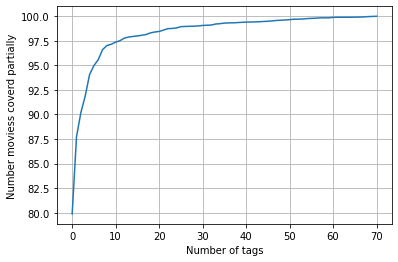

with  5 tags we are covering  94.977 % of movies
with  10 tags we are covering  97.361 % of movies
with  18 tags we are covering  98.306 % of movies
with  20 tags we are covering  98.452 % of movies
with  26 tags we are covering  98.961 % of movies
with  30 tags we are covering  99.062 % of movies
with  35 tags we are covering  99.302 % of movies
with  40 tags we are covering  99.404 % of movies
with  50 tags we are covering  99.651 % of movies
with  60 tags we are covering  99.884 % of movies


In [205]:
fig, ax = plt.subplots()
ax.plot(analysis)
plt.xlabel("Number of tags")
plt.ylabel("Number moviess coverd partially")
plt.grid()
plt.show()

print("with ",5,"tags we are covering ",analysis[5],"% of movies")
print("with ",10,"tags we are covering ",analysis[10],"% of movies")
print("with ",18,"tags we are covering ",analysis[18],"% of movies")
print("with ",20,"tags we are covering ",analysis[20],"% of movies")
print("with ",26,"tags we are covering ",analysis[26],"% of movies")
print("with ",30,"tags we are covering ",analysis[30],"% of movies")
print("with ",35,"tags we are covering ",analysis[35],"% of movies")
print("with ",40,"tags we are covering ",analysis[40],"% of movies")
print("with ",50,"tags we are covering ",analysis[50],"% of movies")
print("with ",60,"tags we are covering ",analysis[60],"% of movies")